# ceLEry Analysis: Domain Prediction

## Xenium Breast Cancer, InSitu Replicate 1

https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer




### Import packages

In [49]:
import os
import CeLEry as cel


import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
from skimage import io, color

from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.model_selection import train_test_split
from anndata import AnnData, read_h5ad, concat
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [50]:
import anndata as ad
from scipy import sparse
from anndata import AnnData
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.pyplot import figure

#Read original data and save it to h5ad
from scanpy import read_10x_h5

In [51]:
def findBlank(name):
    return "Blank" in name

### Load data

In [52]:
# cells to be filtered out based on total UMI and number of genes expressed
os.chdir("")
lowUMI_cellID = pd.read_csv("cell_ID_toRemove_filtered_25_25.csv",sep=",",na_filter=False,index_col=0)

In [53]:
#Read in gene expression and spatial location
os.chdir("")
data_xenium = read_10x_h5("Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
spatial_full = pd.read_csv("Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv",sep=",",na_filter=False,index_col=0)

meta_data = spatial_full
meta_data


x_centroid   y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                      
1         377.663005   843.541888                154                     0   
2         382.078658   858.944818                 64                     0   
3         319.839529   869.196542                 57                     0   
4         259.304707   851.797949                120                     0   
5         370.576291   865.193024                120                     0   
...              ...          ...                ...                   ...   
167778   7455.404785  5115.021094                238                     1   
167779   7483.771045  5111.720703                 80                     0   
167780   7470.119580  5119.350366                406                     0   
167781   7477.704004  5128.963086                120                     0   
167782   7489.376562  5123.402393                393                     0   

         control_codeword_counts  total_counts   cell_area  nucleus_area  
cell_id                                                                   
1                              0           154  110.361875     45.562656  
2                              0            64   87.919219     24.248906  
3                              0            57   52.561875     23.526406  
4                              0           120   75.230312     35.176719  
5                              0           120  180.218594     34.499375  
...                          ...           ...         ...           ...  
167778                         0           239  219.956094     61.412500  
167779                         0            80   38.427969     25.964844  
167780                         0           406  287.690469     86.158125  
167781                         0           120  235.670469     25.016563  
167782                         0           393  269.447344    111.445625  

[167782 rows x 8 columns]

In [54]:
data_xenium.obs['x_cord'] = meta_data['x_centroid'].tolist()
data_xenium.obs['y_cord'] = meta_data['y_centroid'].tolist()
#data_xenium_raw = data_xenium.copy()
blank_lst = np.array(list(map(findBlank, data_xenium.var.index)))
data_xenium = data_xenium[:, blank_lst == False]
data_xenium

View of AnnData object with n_obs × n_vars = 167782 × 313
    obs: 'x_cord', 'y_cord'
    var: 'gene_ids', 'feature_types', 'genome'

In [55]:
os.chdir("")
kmeans10_clustering = pd.read_csv("clusters.csv", index_col=0)
kmeans10_clustering

Cluster
Barcode         
1              5
2              8
3              4
4              1
5              4
...          ...
167778         2
167779         2
167780         2
167781         2
167782         2

[166313 rows x 1 columns]

In [57]:
barcodes = kmeans10_clustering.index.astype(str)
data_xenium_clust = data_xenium.copy()[data_xenium.obs_names.isin(list(barcodes)), :]
data_xenium_clust.obs['clusters'] = kmeans10_clustering['Cluster'].values.astype(str)

data_xenium_clust

AnnData object with n_obs × n_vars = 166313 × 313
    obs: 'x_cord', 'y_cord', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome'

In [58]:
# Filter out cells with low UMI and cells with low number of genes expressed 
data_xenium_clust.obs_names = data_xenium_clust.obs_names.astype(np.int64) 
data_xenium_filtered = data_xenium_clust.copy()[~data_xenium_clust.obs_names.isin(lowUMI_cellID.x), :]
data_xenium_filtered

View of AnnData object with n_obs × n_vars = 121277 × 313
    obs: 'x_cord', 'y_cord', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome'

In [59]:
order = ['1', '2', '3', '5', '4', '6', '7', '8', '9', '10']

### Plot all cells after the filltering criteria

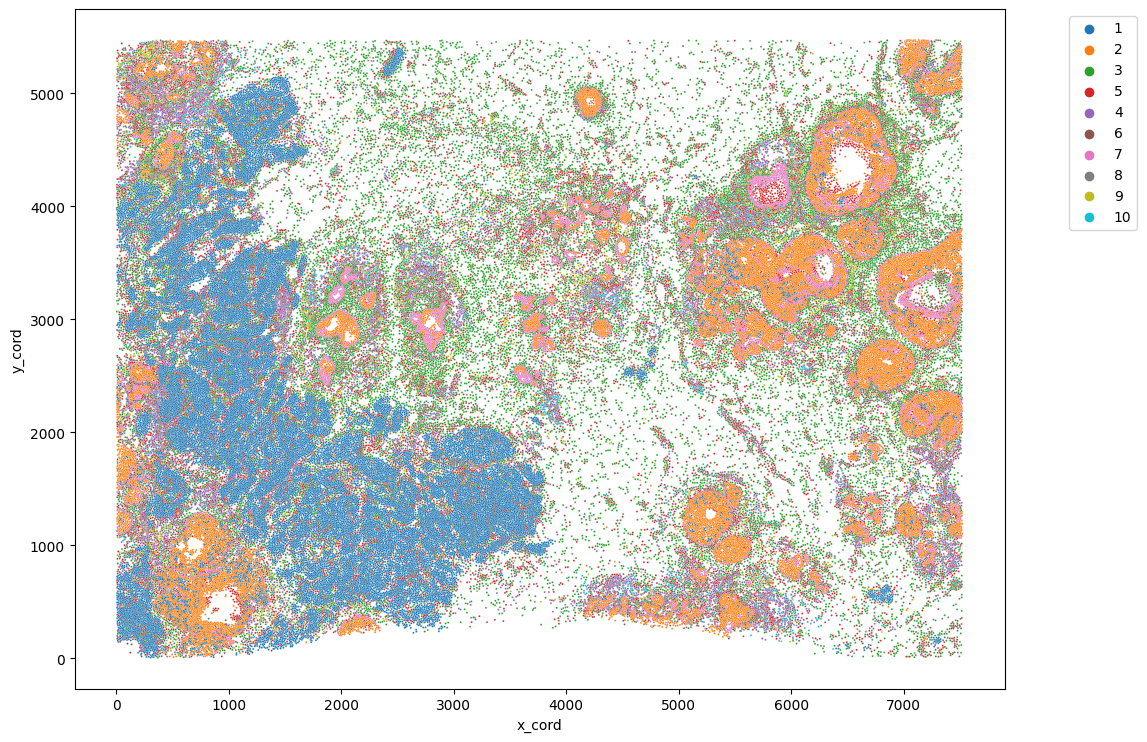

In [60]:
data_filter = data_xenium_filtered.copy()

from matplotlib.pyplot import figure

figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=data_filter.obs, x='x_cord', y='y_cord', hue='clusters',  hue_order=order, s=2)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


In [63]:
data_filter.obs['clusters'] = data_filter.obs['clusters'].astype('category').cat.codes

Rdata_ind, Qdata_ind, _, _ =train_test_split(range(data_filter.shape[0]), data_filter.obs['clusters'], test_size=0.5,random_state=1,stratify=data_filter.obs['clusters'])

Rdata = data_filter[np.sort(Rdata_ind), :]
Qdata = data_filter[np.sort(Qdata_ind), :]
print((Rdata.shape, Qdata.shape))

Rdata.obs


((60638, 313), (60639, 313))


x_cord       y_cord  clusters
4        259.304707   851.797949         0
6        382.014793   851.058765         4
14       368.909494   846.457745         4
23        54.812166   862.695837         6
25       297.857530   868.191940         0
...             ...          ...       ...
167767  7480.027393  5221.799023         2
167768  7461.426172  5221.114209         2
167771  7458.618848  5095.187207         2
167775  7484.152051  5105.957886         2
167777  7465.116699  5108.040967         2

[60638 rows x 3 columns]

In [64]:
## Export the cell barcodes used in the training and test set (for comparable results with the competing methods)

trainCell_index = pd.DataFrame(Rdata.obs.index.astype('int64'))
testCell_index = pd.DataFrame(Qdata.obs.index.astype('int64'))

os.chdir("") #scheme 2
trainCell_index.to_csv("trainCell_index.csv")
testCell_index.to_csv("testCell_index.csv", sep=',')



In [65]:
layer_count =  Rdata.obs["clusters"].value_counts().sort_index()
layer_weight = layer_count[len(layer_count)-1]/layer_count[0:len(layer_count)]

In [66]:
%%capture
cel.get_zscore(Qdata)
cel.get_zscore(Rdata)

In [19]:
output_path_dom = ""


## Run CelERy domain prediction

In [ ]:
cel.Fit_domain (data_train = Rdata, domain_weights = layer_weight, domainkey = "clusters", batch_size=64, 
                            hidden_dims = [125, 75, 30, 20], num_epochs_max = 800, path = output_path_dom, filename = "xenium_rep1_domain")



In [67]:
pred_cord_all = cel.Predict_domain(data_test = Qdata, class_num = 10, path = output_path_dom, filename = "xenium_rep1_domain")


In [68]:
pred_cord_all.shape

(60639, 10)

In [69]:
data_xenium_filtered.obs['clusters'] = data_xenium_filtered.obs['clusters'].astype('category')
d = dict(enumerate(data_xenium_filtered.obs['clusters'].cat.categories))

In [70]:
d

{0: '1',
 1: '10',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [71]:
Qdata.obs['clusters_int'] = Qdata.obs['clusters'].astype('int64')
Qdata.obs['clusters_int'].map(d)

1         5
5         4
7         1
8         8
9         9
         ..
167776    2
167778    2
167780    2
167781    2
167782    2
Name: clusters_int, Length: 60639, dtype: object

In [72]:
Qdata.obs['pred_domain'].map(d)

1         5
5         4
7         1
8         8
9         9
         ..
167776    2
167778    2
167780    2
167781    2
167782    2
Name: pred_domain, Length: 60639, dtype: object

In [73]:
Qdata.obs['clusters_true'] = Qdata.obs['clusters_int'].map(d)
Qdata.obs['pred_layer'] = Qdata.obs['pred_domain'].map(d)

In [75]:
np.sum(Qdata.obs['clusters_true'].values == Qdata.obs['pred_layer'].values)/Qdata.shape[0]

0.9628127112914131

## Plot true querry data domains:

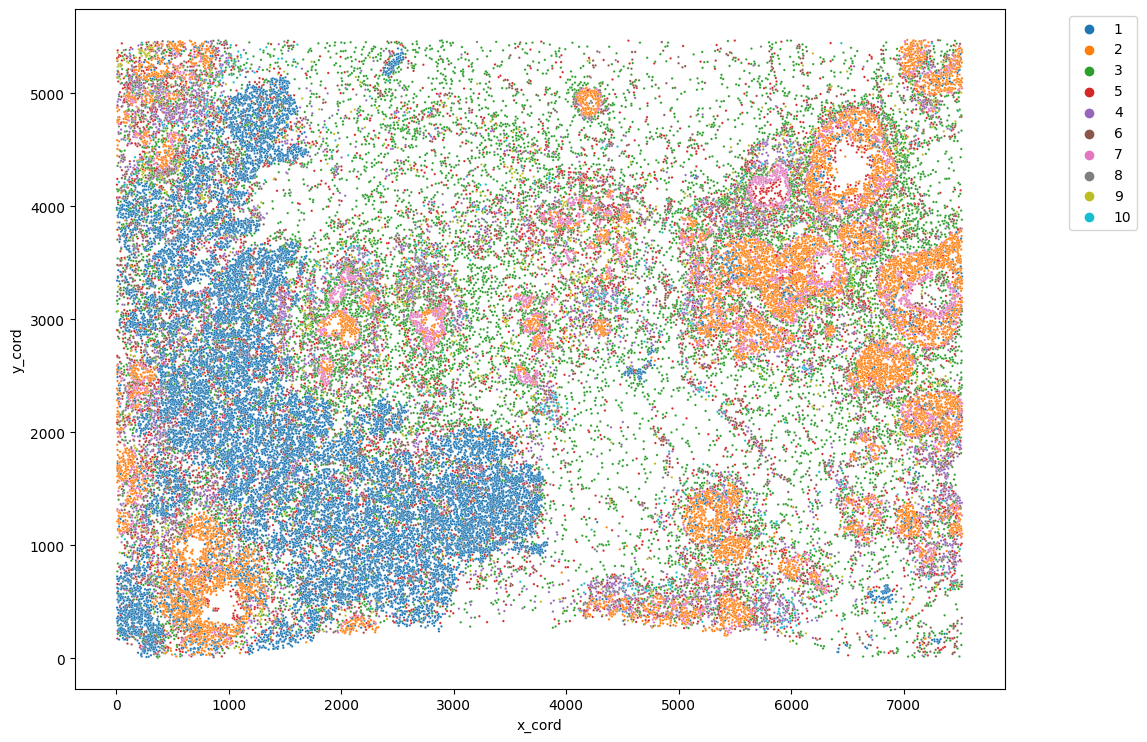

In [77]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=Qdata.obs, x='x_cord', y='y_cord', hue='clusters_true',  hue_order=order, s=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


## Plot predicted querry data domains:

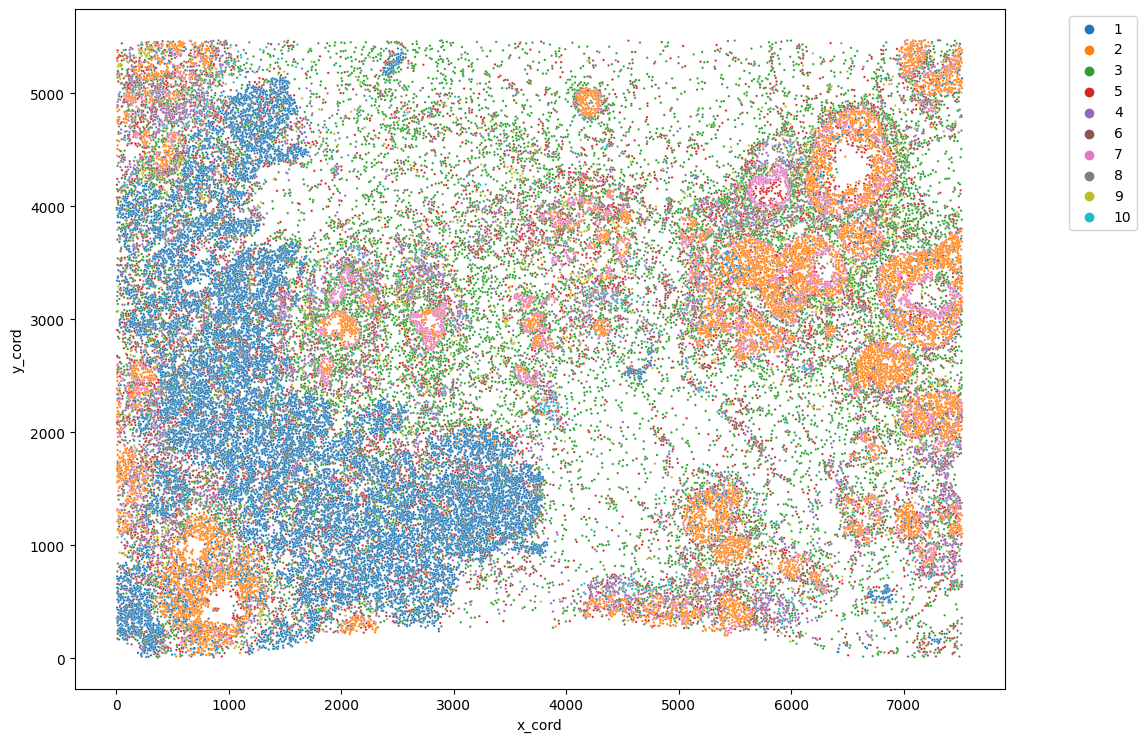

In [78]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=Qdata.obs, x='x_cord', y='y_cord', hue='pred_layer',  hue_order=order, s=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))



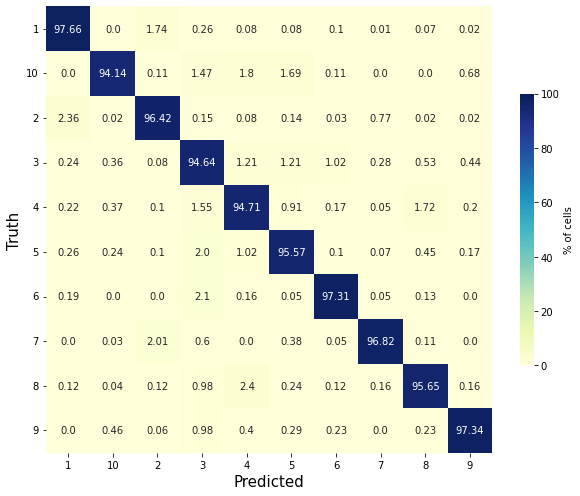

In [79]:

type_pred = np.array(Qdata.obs['pred_layer'].values)

contigency = pd.crosstab(Qdata.obs['clusters_true'], type_pred)


for i in range(contigency.shape[0]):
    contigency.iloc[i,:] = contigency.iloc[i,:]/np.sum(contigency, axis=1)[i] * 100

fig = plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

annot_m = np.empty(contigency.shape,dtype='<U16')
for i in range(contigency.shape[0]):
    for j in range(contigency.shape[0]):
        annot_m[i,j] = np.round(contigency.iloc[i,j], 2)

res = sns.heatmap(contigency, annot=annot_m, fmt="", cmap="YlGnBu", vmin=0.0, vmax=100, cbar_kws={'label': '% of cells', "shrink": 0.5}).set(ylabel="Truth", xlabel="Predicted")
cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(10)
# cbar = res.collections[0].colorbar
# cbar.set_label('Label for colour bar axis', labelpad=40)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Truth", fontsize=15)

plt.xticks([i+0.5 for i in range(contigency.shape[0])], list(contigency.index))
plt.xticks(rotation=0)

plt.yticks([i+0.5 for i in range(contigency.shape[1])], list(contigency.index))
plt.yticks(rotation=0)

plt.yticks(rotation=0)

os.chdir("")


plt.show()

